# Creating a wildtype (WT / PD0), and Parkinson degeneration (PD2) network

In the directory ```network_path``` we have three sub directories ```PD0```, ```PD2-ref``` and ```PD2```. In order to generate the ```PD2``` network, we degenerate the ```PD0``` network by swapping the WT morphologies for the PD2 morphologies. In addition a subset of the synapses in the ```PD2-ref``` network are added to compensate for differences in pruning.

We need to specify a ```connection_override``` file. The difference compared to the standard connection file is that it contains ```recovery``` information, i.e. the fraction of synapses from the ```PD2-ref``` network that should be added to the ```PD2``` network.

The ```rc``` object is a ```ipyparallel``` ```RemoteClient``` object for parallel execution.

If you want to remap external input that was removed to a new position, then use ```remap_removed_input = True```

In [1]:
import os

network_path = os.path.join("networks","PD-example-2")
#network_path = os.path.join("networks","PD-example-2_ref_0.9")

network_path_pd0 = os.path.join(network_path, "PD0")
network_path_pd2_ref = os.path.join(network_path, "PD2-ref")
network_path_pd2 = os.path.join(network_path, "PD2")

network_size = 200
input_config = "test-input.json"  # Only background input will be used in this example

snudda_data_base_path = os.path.join("..", "..", "..", "..", "BasalGangliaData", "Parkinson", "20221213")
snudda_data_pd0 = os.path.join(snudda_data_base_path, "PD0")
snudda_data_pd2 = os.path.join(snudda_data_base_path, "PD2")

network_config_pd0 = os.path.join(snudda_data_base_path, "connectivity", "network-config.json")
network_config_pd2 = os.path.join(snudda_data_base_path, "connectivity", "network-config-PD-synapse-recovery.json")

input_pd0 = os.path.join(network_path_pd0, "input-spikes.hdf5")
input_pd2 = os.path.join(network_path_pd2, "input-spikes.hdf5")

# Do we want to remap removed input?
remap_removed_input = False
remapped_fraction = 0.0

# Do we want to remap removed input?
#remap_removed_input = True
#remapped_fraction = 0.9

rc = None

## First generate the WT reference network

In [2]:
from snudda import SnuddaInit

si = SnuddaInit(network_path=network_path_pd0, random_seed=123456, snudda_data=snudda_data_pd0,
                struct_def={"Striatum": network_size}, connection_override_file=network_config_pd0)

Adding Striatum with 200 neurons (stay_inside=False)
Using cube for striatum
Neurons for striatum read from /home/hjorth/HBP/BasalGangliaData/Parkinson/20221213/PD0/neurons/striatum
Adding neurons: FS from dir /home/hjorth/HBP/BasalGangliaData/Parkinson/20221213/PD0/neurons/striatum/fs
No parameter.json file.
No parameter.json file.
No parameter.json file.
No parameter.json file.
Parameter file not found: /home/hjorth/HBP/BasalGangliaData/Parkinson/20221213/PD0/neurons/striatum/fs/0/parameters.json
Mechanism file not found: /home/hjorth/HBP/BasalGangliaData/Parkinson/20221213/PD0/neurons/striatum/fs/0/mechanisms.json
Parameter file not found: /home/hjorth/HBP/BasalGangliaData/Parkinson/20221213/PD0/neurons/striatum/fs/1/parameters.json
Mechanism file not found: /home/hjorth/HBP/BasalGangliaData/Parkinson/20221213/PD0/neurons/striatum/fs/1/mechanisms.json
Parameter file not found: /home/hjorth/HBP/BasalGangliaData/Parkinson/20221213/PD0/neurons/striatum/fs/3/parameters.json
Mechanism fi

In [3]:
from snudda import Snudda
snd_pd0 = Snudda(network_path=network_path_pd0)
snd_pd0.create_network()

Placing neurons
Network path: networks/PD-example-2/PD0
Reading SNUDDA_DATA=../../../../BasalGangliaData/Parkinson/20221213/PD0 from networks/PD-example-2/PD0/network-config.json
Generating 1094 points for networks/PD-example-2/PD0/mesh/Striatum-cube-mesh-0.00013543930142996346.obj
n_points = 1042, previous close_pairs = 1680
n_points = 993, previous close_pairs = 1368
n_points = 946, previous close_pairs = 1139
n_points = 902, previous close_pairs = 942
n_points = 861, previous close_pairs = 778
n_points = 823, previous close_pairs = 651
n_points = 787, previous close_pairs = 547
n_points = 754, previous close_pairs = 451
n_points = 725, previous close_pairs = 374
n_points = 698, previous close_pairs = 319
n_points = 674, previous close_pairs = 267
n_points = 653, previous close_pairs = 219
n_points = 646, previous close_pairs = 180
n_points = 479, previous close_pairs = 167
Filtering 479 points..
Filtering, keeping inside points: 239 / 479
stop_parallel disabled, to keep pool running

In [4]:
snd_pd0.setup_input(input_config=input_config)

Setting up inputs, assuming input.json exists
Reading SNUDDA_DATA=../../../../BasalGangliaData/Parkinson/20221213/PD0 from networks/PD-example-2/PD0/network-config.json
Writing input spikes to networks/PD-example-2/PD0/input-spikes.hdf5
Reading SNUDDA_DATA=../../../../BasalGangliaData/Parkinson/20221213/PD0 from networks/PD-example-2/PD0/network-config.json
Writing spikes to networks/PD-example-2/PD0/input-spikes.hdf5
stop_parallel disabled, to keep pool running.

Execution time: 22.5s


## Generate a PD2 reference network

This network will not have the same synapses as the WT, but it is used in order to add "recovery synapses" to compensate for part of the degeneration.

In [5]:
from snudda import SnuddaInit

si = SnuddaInit(network_path=network_path_pd2_ref, random_seed=123456, snudda_data=snudda_data_pd2,
                struct_def={"Striatum": network_size}, connection_override_file=network_config_pd2)

Adding Striatum with 200 neurons (stay_inside=False)
Using cube for striatum
Neurons for striatum read from /home/hjorth/HBP/BasalGangliaData/Parkinson/20221213/PD2/neurons/striatum
Adding neurons: FS from dir /home/hjorth/HBP/BasalGangliaData/Parkinson/20221213/PD3/neurons/striatum/fs
No parameter.json file.
No parameter.json file.
No parameter.json file.
No parameter.json file.
Parameter file not found: /home/hjorth/HBP/BasalGangliaData/Parkinson/20221213/PD3/neurons/striatum/fs/0/parameters.json
Mechanism file not found: /home/hjorth/HBP/BasalGangliaData/Parkinson/20221213/PD3/neurons/striatum/fs/0/mechanisms.json
Parameter file not found: /home/hjorth/HBP/BasalGangliaData/Parkinson/20221213/PD3/neurons/striatum/fs/1/parameters.json
Mechanism file not found: /home/hjorth/HBP/BasalGangliaData/Parkinson/20221213/PD3/neurons/striatum/fs/1/mechanisms.json
Parameter file not found: /home/hjorth/HBP/BasalGangliaData/Parkinson/20221213/PD3/neurons/striatum/fs/3/parameters.json
Mechanism fi

In [6]:
from snudda import Snudda
snd_pd2_ref = Snudda(network_path=network_path_pd2_ref)
snd_pd2_ref.create_network()

Placing neurons
Network path: networks/PD-example-2/PD2-ref
Reading SNUDDA_DATA=../../../../BasalGangliaData/Parkinson/20221213/PD2 from networks/PD-example-2/PD2-ref/network-config.json
Generating 1094 points for networks/PD-example-2/PD2-ref/mesh/Striatum-cube-mesh-0.00013543930142996346.obj
n_points = 1042, previous close_pairs = 1680
n_points = 993, previous close_pairs = 1368
n_points = 946, previous close_pairs = 1139
n_points = 902, previous close_pairs = 942
n_points = 861, previous close_pairs = 778
n_points = 823, previous close_pairs = 651
n_points = 787, previous close_pairs = 547
n_points = 754, previous close_pairs = 451
n_points = 725, previous close_pairs = 374
n_points = 698, previous close_pairs = 319
n_points = 674, previous close_pairs = 267
n_points = 653, previous close_pairs = 219
n_points = 646, previous close_pairs = 180
n_points = 479, previous close_pairs = 167
Filtering 479 points..
Filtering, keeping inside points: 239 / 479
stop_parallel disabled, to keep 

In [7]:
snd_pd2_ref.setup_input(input_config=input_config)

Setting up inputs, assuming input.json exists
Reading SNUDDA_DATA=../../../../BasalGangliaData/Parkinson/20221213/PD2 from networks/PD-example-2/PD2-ref/network-config.json
Writing input spikes to networks/PD-example-2/PD2-ref/input-spikes.hdf5
Reading SNUDDA_DATA=../../../../BasalGangliaData/Parkinson/20221213/PD2 from networks/PD-example-2/PD2-ref/network-config.json
Writing spikes to networks/PD-example-2/PD2-ref/input-spikes.hdf5
stop_parallel disabled, to keep pool running.

Execution time: 19.3s


## Degenerating the PD0 network to get PD2 network

In [8]:
network_file_pd0 = os.path.join(network_path_pd0, "network-synapses.hdf5")
network_file_pd2_ref = os.path.join(network_path_pd2_ref, "network-synapses.hdf5")
network_file_pd2 = os.path.join(network_path_pd2, "network-synapses.hdf5")

from snudda.utils.swap_to_degenerated_morphologies_extended import SwapToDegeneratedMorphologiesExtended
swap = SwapToDegeneratedMorphologiesExtended(original_network_file=network_file_pd0,
                                             updated_network_file=network_file_pd2_ref,
                                             output_network_file=network_file_pd2,
                                             original_snudda_data_dir=snudda_data_pd0,
                                             updated_snudda_data_dir=snudda_data_pd2,
                                             original_input_file=input_pd0,
                                             output_input_file=input_pd2)
swap.write_new_network_file()
swap.write_new_input_file(remap_removed_input=remap_removed_input, remapped_fraction=remapped_fraction)
swap.close()

Failed to load cache from /home/hjorth/HBP/BasalGangliaData/Parkinson/20221213/PD2/neurons/striatum/fs/0/BE104E-cor-rep-res3-61.swc-cache.pickle
Failed to load cache from /home/hjorth/HBP/BasalGangliaData/Parkinson/20221213/PD2/neurons/striatum/chin/str-chin-e170614_cell6-m17JUL301751_170614_no6_MD_cell_1_x63-v20190710/optim_chin_morph_renamed2019-11-08.swc-cache.pickle
Failed to load cache from /home/hjorth/HBP/BasalGangliaData/Parkinson/20221213/PD2/neurons/striatum/fs/1/DR-rat-Mar-13-08-1-536-R-cor-rep-res3-61.swc-cache.pickle
Failed to load cache from /home/hjorth/HBP/BasalGangliaData/Parkinson/20221213/PD2/neurons/striatum/fs/3/MTC251001A-IDB-cor-rep-res3-61.swc-cache.pickle
Failed to load cache from /home/hjorth/HBP/BasalGangliaData/Parkinson/20221213/PD2/neurons/striatum/lts/8/lts_morp_9862_centered_no_axon_resampled-var8.swc-cache.pickle
Writing new network to networks/PD-example-2/PD2/network-synapses.hdf5
Loading synapses into memory.
Failed to load cache from /home/hjorth/HB

## Plotting of a degenerated neuron

In [9]:
# This is so we get the most central dSPN in the network
from snudda import SnuddaLoad
sl = SnuddaLoad(network_path_pd0)
neuron_id = list(sl.get_centre_neurons_iterator(neuron_type="dSPN", n_neurons=1))[0][0]

In [10]:
# neuron_id = 55
neuron_id

44

Reading SNUDDA_DATA=../../../../BasalGangliaData/Parkinson/20221213/PD0 from networks/PD-example-2/PD0/network-config.json
Reading SNUDDA_DATA=../../../../BasalGangliaData/Parkinson/20221213/PD0 from networks/PD-example-2/PD0/network-config.json
Plotting 200 external synapses
Plotting 200 external synapses


/home/hjorth/HBP/Snudda/snudda/plotting/plot_input_locations.py:118: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(xs=coords[:, 0], ys=coords[:, 1], zs=coords[:, 2],
/home/hjorth/HBP/Snudda/snudda/plotting/plot_input_locations.py:125: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(xs=syn_coords[:, 0], ys=syn_coords[:, 1], zs=syn_coords[:, 2],
/home/hjorth/HBP/Snudda/snudda/plotting/plot_input_locations.p

Figure written: networks/PD-example-2/PD0/figures/input-to-44-dSPN_10-and-internal-synapses.png


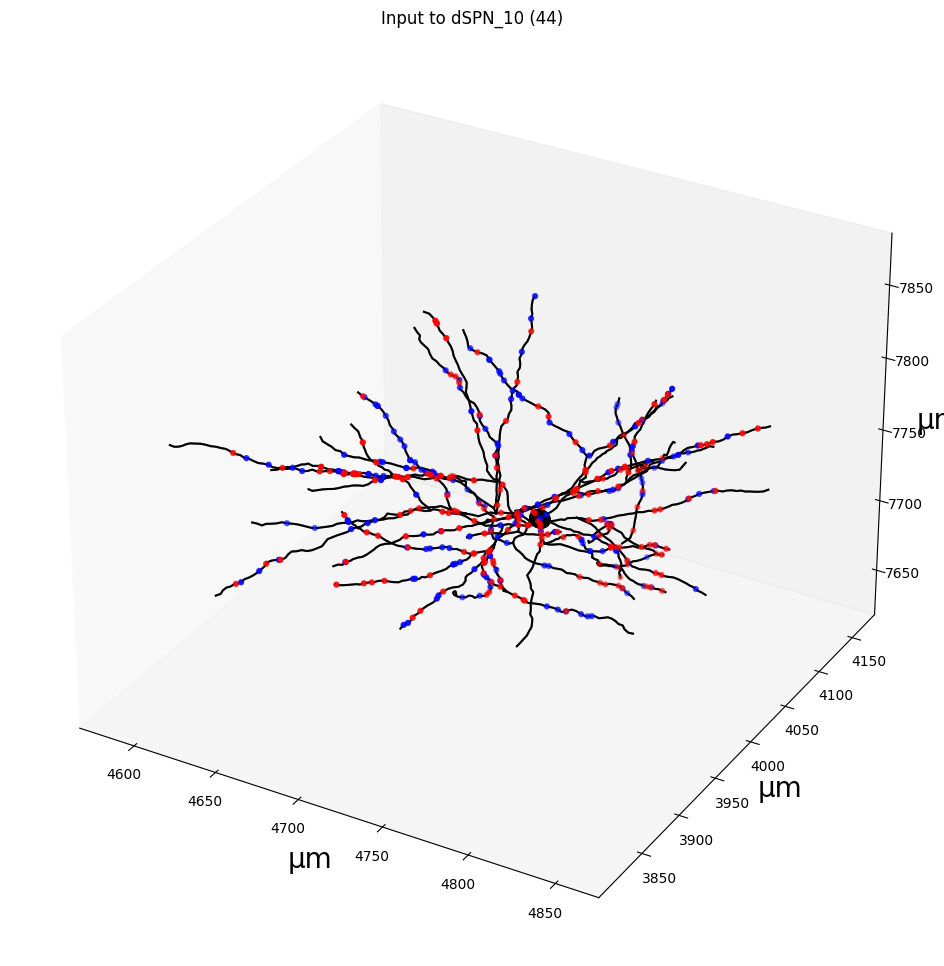

In [11]:
%matplotlib inline
from snudda.plotting.plot_degeneration import PlotDegeneration

# Note here original and degenerate path were the same, so we are plotting the full neuron and its synapses.
pd = PlotDegeneration(original_network_path=network_path_pd0,
                      degenerated_network_path=network_path_pd0)

pd.plot_neuron(neuron_id=neuron_id, figure_size=(12,12), 
               show_internal_synapses=True, hide_axis=False)
#internal synapses are blue
#external synapses are red

Reading SNUDDA_DATA=../../../../BasalGangliaData/Parkinson/20221213/PD0 from networks/PD-example-2/PD0/network-config.json
Reading SNUDDA_DATA=../../../../BasalGangliaData/Parkinson/20221213/PD2 from networks/PD-example-2/PD2/network-synapses.hdf5
Plotting 200 external synapses
Plotting 103 external synapses
Figure written: networks/PD-example-2/PD2/figures/input-to-44-dSPN_10-and-internal-synapses.png


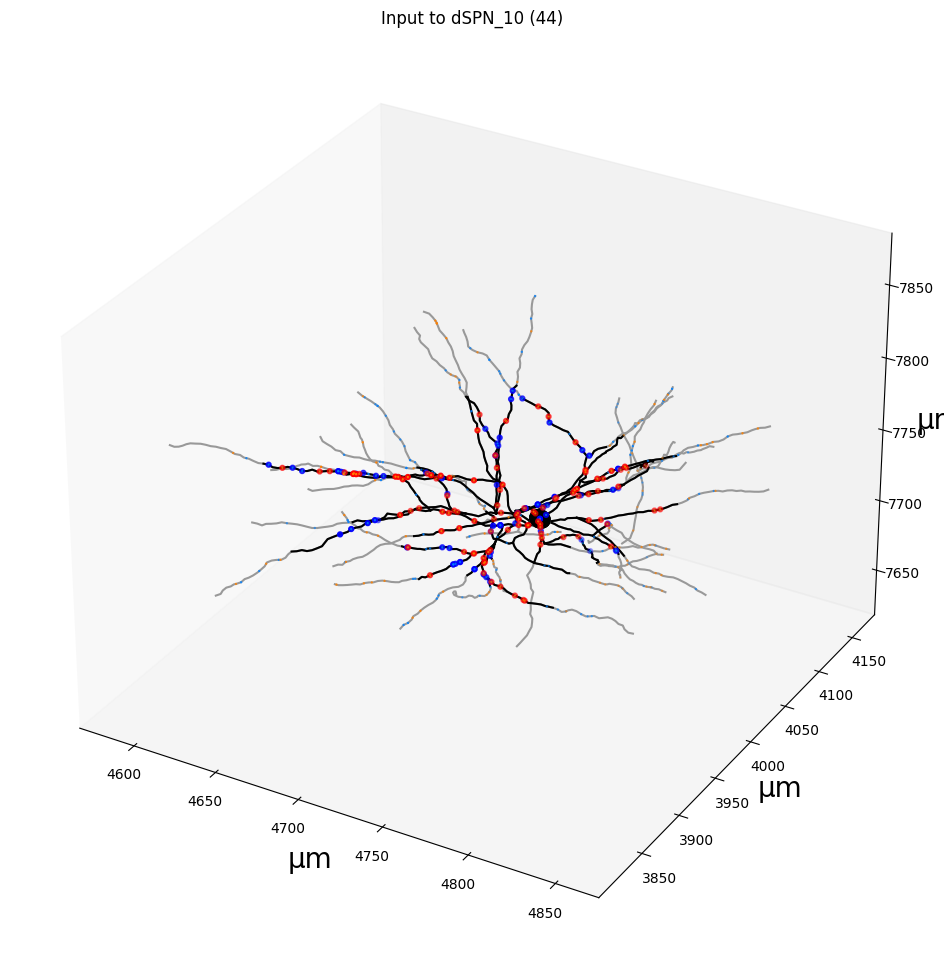

In [12]:
%matplotlib inline
from snudda.plotting.plot_degeneration import PlotDegeneration

pd = PlotDegeneration(original_network_path=network_path_pd0,
                      degenerated_network_path=network_path_pd2)

pd.plot_neuron(neuron_id=neuron_id, figure_size=(12,12), 
               show_internal_synapses=True, hide_axis=False)

Reading SNUDDA_DATA=../../../../BasalGangliaData/Parkinson/20221213/PD0 from networks/PD-example-2/PD0/network-config.json
Reading SNUDDA_DATA=../../../../BasalGangliaData/Parkinson/20221213/PD2 from networks/PD-example-2/PD2-ref/network-config.json
Plotting 200 external synapses
Plotting 200 external synapses
Figure written: networks/PD-example-2/PD2-ref/figures/input-to-44-dSPN_10-and-internal-synapses.png


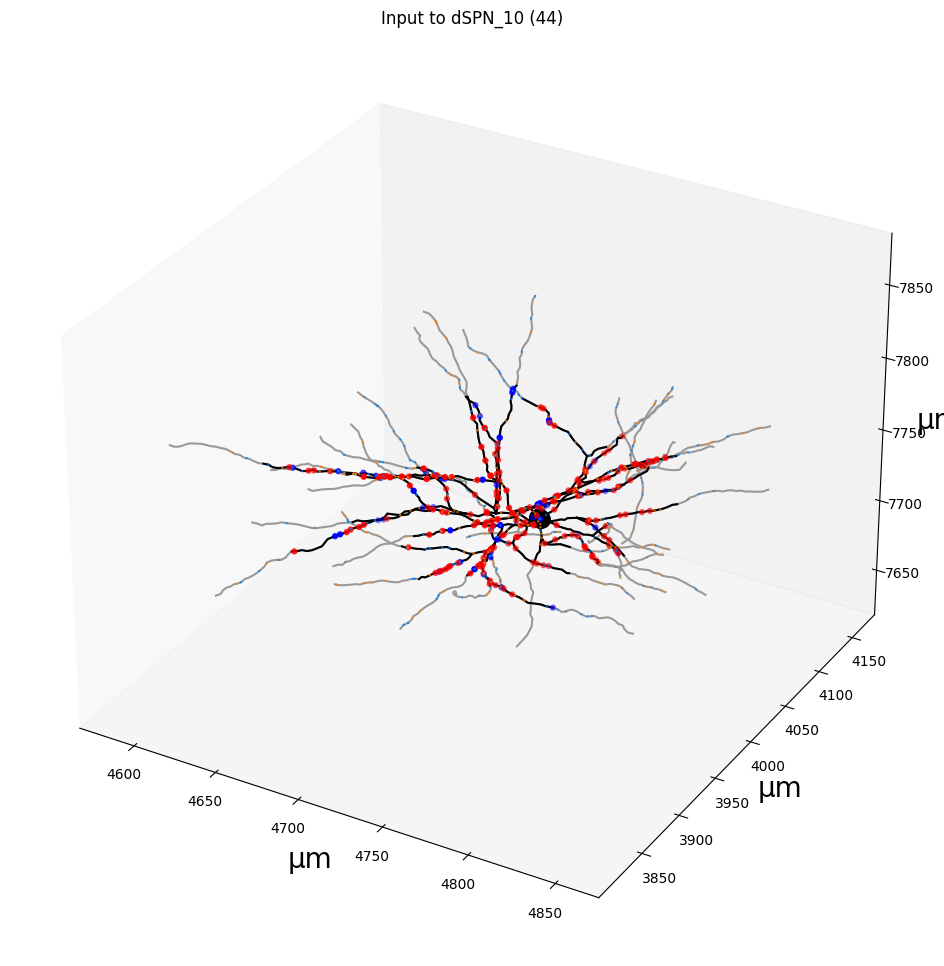

In [13]:
%matplotlib inline
from snudda.plotting.plot_degeneration import PlotDegeneration

pd = PlotDegeneration(original_network_path=network_path_pd0,
                      degenerated_network_path=network_path_pd2_ref)
#neuron_id = 55
pd.plot_neuron(neuron_id=neuron_id, figure_size=(12,12), 
               show_internal_synapses=True, hide_axis=False)

In [14]:
from snudda.analyse.analyse_input import AnalyseInput

pd0_input_info = AnalyseInput(input_file=input_pd0, network_path=network_path_pd0)
pd2_input_info = AnalyseInput(input_file=input_pd2, network_path=network_path_pd2)

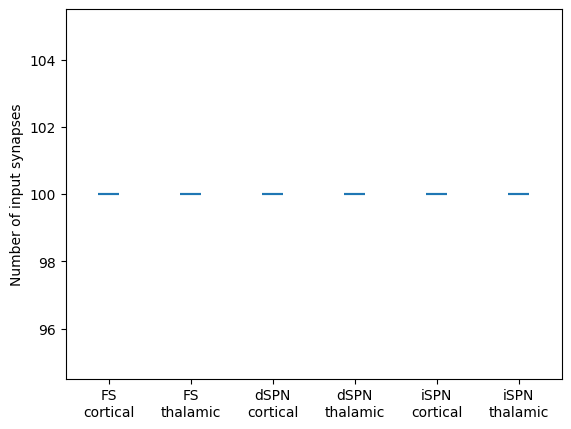

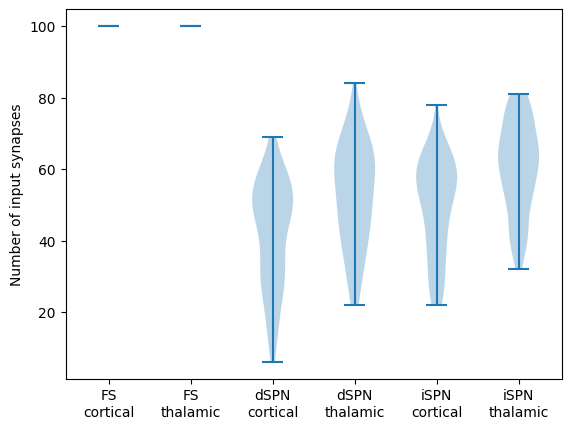

In [15]:
pd0_input_info.plot_input_count("PD0-input_example.png")
pd2_input_info.plot_input_count("PD2-input_example.png")

In [16]:
cmd_str1 = f"snudda_load {network_path_pd0}/network-synapses.hdf5 --countSyn"
cmd_str2 = f"snudda_load {network_path_pd2}/network-synapses.hdf5 --countSyn"
cmd_str3 = f"snudda_load {network_path_pd2_ref}/network-synapses.hdf5 --countSyn"

print("WT")
os.system(cmd_str1)
print("\nPD2")
os.system(cmd_str2)
print("\nPD2 degenerated")
os.system(cmd_str3)

WT
Loading networks/PD-example-2/PD0/network-synapses.hdf5
Loading config data from HDF5
Loading 200 neurons with 21633 synapses and 0 gap junctions
Load done. 0.0
ChIN -> LTS: 5 synapses
ChIN -> dSPN: 116 synapses
ChIN -> iSPN: 160 synapses
FS -> FS: 2 synapses
FS -> dSPN: 700 synapses
FS -> iSPN: 376 synapses
LTS -> ChIN: 17 synapses
LTS -> dSPN: 18 synapses
LTS -> iSPN: 7 synapses
dSPN -> ChIN: 8 synapses
dSPN -> dSPN: 4721 synapses
dSPN -> iSPN: 1105 synapses
iSPN -> ChIN: 3 synapses
iSPN -> dSPN: 5671 synapses
iSPN -> iSPN: 8724 synapses

PD2
Loading networks/PD-example-2/PD2/network-synapses.hdf5
Loading config data from HDF5
Loading 200 neurons with 9492 synapses and 0 gap junctions
Load done. 0.0
ChIN -> LTS: 5 synapses
ChIN -> dSPN: 92 synapses
ChIN -> iSPN: 72 synapses
FS -> FS: 3 synapses
FS -> dSPN: 619 synapses
FS -> iSPN: 891 synapses
LTS -> ChIN: 17 synapses
LTS -> dSPN: 10 synapses
dSPN -> ChIN: 8 synapses
dSPN -> dSPN: 1499 synapses
dSPN -> iSPN: 423 synapses
iSPN -> C

0

In [17]:
cmd_str1 = f"snudda_load {network_path_pd0}/network-synapses.hdf5 --listPre {neuron_id}"
cmd_str2 = f"snudda_load {network_path_pd2}/network-synapses.hdf5 --listPre {neuron_id}"
cmd_str3 = f"snudda_load {network_path_pd2_ref}/network-synapses.hdf5 --listPre {neuron_id}"

print("WT")
os.system(cmd_str1)
print("\nPD2")
os.system(cmd_str2)
print("\nPD2 degenerated")
os.system(cmd_str3)

WT
Loading networks/PD-example-2/PD0/network-synapses.hdf5
Loading config data from HDF5
Loading 200 neurons with 21633 synapses and 0 gap junctions
Load done. 0.0
List neurons pre-synaptic to neuron_id = 44 (dSPN_10)
The neuron receives 193 synapses
0 : dSPN_7 (3 synapses)
1 : iSPN_19 (5 synapses)
4 : iSPN_9 (3 synapses)
7 : dSPN_1 (3 synapses)
8 : dSPN_22 (3 synapses)
10 : iSPN_0 (5 synapses)
20 : iSPN_8 (3 synapses)
26 : dSPN_20 (2 synapses)
27 : iSPN_17 (7 synapses)
31 : iSPN_35 (5 synapses)
32 : FS_0 (6 synapses)
38 : dSPN_30 (2 synapses)
40 : dSPN_25 (2 synapses)
51 : iSPN_17 (2 synapses)
54 : iSPN_7 (5 synapses)
62 : iSPN_0 (3 synapses)
65 : dSPN_16 (2 synapses)
67 : iSPN_1 (3 synapses)
69 : iSPN_2 (4 synapses)
73 : iSPN_22 (4 synapses)
76 : iSPN_19 (6 synapses)
80 : iSPN_4 (3 synapses)
81 : iSPN_6 (3 synapses)
89 : dSPN_13 (2 synapses)
90 : dSPN_21 (3 synapses)
91 : iSPN_5 (4 synapses)
93 : dSPN_29 (2 synapses)
94 : dSPN_31 (3 synapses)
96 : FS_1 (5 synapses)
98 : iSPN_16 (3 sy

0

Added: 10, removed: 122, kept: 56


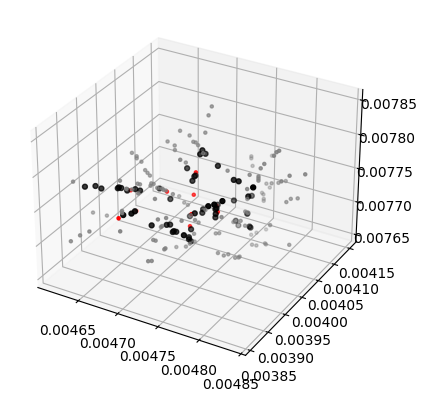

(<Figure size 640x480 with 1 Axes>, <Axes3D: >)

In [18]:
from snudda.plotting.plot_degeneration_and_growth import PlotDegenerationAndGrowth
pdg = PlotDegenerationAndGrowth(original_network_path=network_path_pd0, 
                                degenerated_network_path=network_path_pd2, 
                                neuron_id=neuron_id)
pdg.plot_synapses()

Added: 36, removed: 162, kept: 16


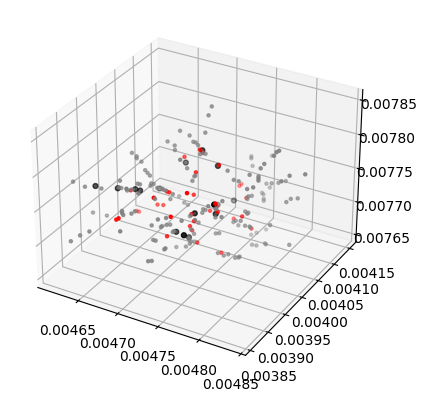

(<Figure size 640x480 with 1 Axes>, <Axes3D: >)

In [19]:
from snudda.plotting.plot_degeneration_and_growth import PlotDegenerationAndGrowth
pdg = PlotDegenerationAndGrowth(original_network_path=network_path_pd0, 
                                degenerated_network_path=network_path_pd2_ref, 
                                neuron_id=neuron_id)
pdg.plot_synapses()